# Link Level Simulation for Physical Downlink Shared Channel (PDSCH) in 5G Non Terrestrial Networks (NTN)

**Key Performance Parameters**
- Throughput vs SNR
- BLER vs SNR


## Import Python Libraries

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

## Import 5G-Toolkit Libraries

In [2]:
import sys
sys.path.append("../../")

from toolkit5G.PhysicalChannels.PDSCH import ComputeTransportBlockSize
from toolkit5G.PhysicalChannels       import PDSCHLowerPhy, PDSCHUpperPhy, PDSCHDecoderLowerPhy, PDSCHDecoderUpperPhy
from toolkit5G.ChannelModels          import AntennaArrays, ParameterGeneratorTDL
from toolkit5G.Configurations         import PDSCHLowerPhyConfiguration, PDSCHUpperPhyConfiguration
from toolkit5G.ChannelProcessing      import AddNoise, ApplyChannel
from toolkit5G.SymbolMapping          import Mapper, Demapper
from toolkit5G.ReceiverAlgorithms     import ChannelEstimationAndEqualizationPDSCH
from toolkit5G.Scrambler              import DeScrambler, Scrambler
from toolkit5G.PhysicalChannels.PDSCH import LayerDemapper


## Simulation Parameters

In [3]:
terrain          = "NTN-TDL-C"            # Propagation Scenario or Terrain for BS-UE links

carrierFrequency = 2*10**9                # carrier frequency in Hz
mu               = 0                      # numerology
scs              = (2**mu)*(15*10**3)     # sub-carrier spacing

slotNumber       = 0                      # slot number. Note that number of slots per sub-frame of 1 ms is 2**mu
numRB            = 24 #270                # Please don't change this. The simulation will break down
Bandwidth        = numRB*scs  
Nfft             = 1024

numBatches       = 100                   # Number of batches considered for simulation
numBSs           = 1                      # number of BSs 
numUEs           = 1                      # number of UEs

txAntStruture    = np.array([1,1,1,1,1], dtype=int)
rxAntStruture    = np.array([1,1,1,1,1], dtype=int)
Nt               = txAntStruture.prod() # number of Tx antenna
Nr               = rxAntStruture.prod() # number of Rx antenna

# Velocity of UEs is generated uniformly at randomly between [minVelocity, maxVelocity]
minVelocity      = 3*5/18                 # Minimum velocity of the UEs
maxVelocity      = 3*5/18                 # Maximum velocity of the UEs

print("************ Simulation Parameters *************")
print()
print("     numBatches: "+str(numBatches))
print("          numRB: "+str(numRB))
print("       fft Size: "+str(Nfft))
print("         numBSs: "+str(numBSs))
print("         numUEs: "+str(numUEs))
print("            scs: "+str(scs))
print("     slotNumber: "+str(slotNumber))
print("        terrain: "+str(terrain))
print("Tx Ant Struture: "+str(txAntStruture))
print("Rx Ant Struture: "+str(rxAntStruture))
print()
print("********************************************")

************ Simulation Parameters *************

     numBatches: 100
          numRB: 24
       fft Size: 1024
         numBSs: 1
         numUEs: 1
            scs: 15000
     slotNumber: 0
        terrain: NTN-TDL-C
Tx Ant Struture: [1 1 1 1 1]
Rx Ant Struture: [1 1 1 1 1]

********************************************


## Generate Channel

In [4]:
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = rxAntStruture)
ueAntArray()

bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = txAntStruture)
bsAntArray()

nSnapShots               = 14
# timeInstances            = np.array([0])
timeInstances            = np.arange(nSnapShots)/(28000)

radiusOfEarth            = 6371*10**3
satelliteAltitude        = 160*10**3
satelliteElevationAngle  = 50*np.pi/180
enableSpatialConsistency = False
correlationDistance      = 10
numSinusoids             = 1024
correlationMatrix        = None

print("       nSnapShots:"+str(nSnapShots))

paramGen  = ParameterGeneratorTDL(terrain, carrierFrequency = carrierFrequency, numTransmitter = numBSs, numReceiver = numUEs, 
                                  timeInstances = timeInstances, minVelocity = minVelocity, maxVelocity = maxVelocity, radiusOfEarth = radiusOfEarth,
                                  satelliteAltitude = satelliteAltitude, satelliteElevationAngle = satelliteElevationAngle, 
                                  enableSpatialConsistency = enableSpatialConsistency, correlationDistance = correlationDistance,
                                  numTxAntennas = Nt, numRxAntennas = Nr, numSinusoids = numSinusoids, correlationMatrix = correlationMatrix)

delaySpread   = 100*(10**-9)
kFactor       = None
muNLoSBias    = None
sigmaNLoSBias = None

paramGen(delaySpread = delaySpread, kFactor = kFactor, muNLoSBias = muNLoSBias, sigmaNLoSBias = sigmaNLoSBias)
channel   = paramGen.getChannels()

Hf        = np.sqrt(Nfft)*channel.ofdm(subCarrierSpacing = scs, fftSize = Nfft, normalizeChannel = False) # np.sqrt(Nfft) factor is used to normalize the average subcarrier power to 1.

print("     coefficients:"+str(channel.coefficients.shape))
print("           delays:"+str(channel.delays.shape))
print("               Hf:"+str(Hf.shape))
print()

       nSnapShots:14
     coefficients:(1, 14, 1, 1, 3, 1, 1)
           delays:(1, 1, 1, 1, 3)
               Hf:(1, 14, 1, 1, 1024, 1, 1)



## PDSCH Configurations

In [5]:
########################################## PDSCH Lower Physical Layer Parameters #########################################
pdschLowerPhyConfig    = PDSCHLowerPhyConfiguration(rank = 1, startSymbol=2, numSymbols=12, pdschMappingType = "PDSCH-mapping-type-A", 
                                                    maxLength = "len1", dmrsAdditionalPosition = "pos0", l0 = 0,
                                                    configurationType = "Configuration-type-1")
pdschMappingType       = pdschLowerPhyConfig.pdschMappingType   # "PDSCH mapping type A" or "PDSCH mapping type B"
maxLength              = pdschLowerPhyConfig.maxLength
startSymbol            = pdschLowerPhyConfig.startSymbol
numSymbols             = pdschLowerPhyConfig.numSymbols
betaDMRS               = pdschLowerPhyConfig.betaDMRS
configurationType      = pdschLowerPhyConfig.configurationType   # "Configuration-type-1" or "Configuration-type-2"
dmrsTypeAPosition      = pdschLowerPhyConfig.dmrsTypeAPosition                                   # "pos2" or "pos3"
dmrsAdditionalPosition = pdschLowerPhyConfig.dmrsAdditionalPosition  # "pos2" or "pos3"
ld                     = pdschLowerPhyConfig.ld
l0                     = pdschLowerPhyConfig.l0
l1                     = pdschLowerPhyConfig.l1
rank                   = pdschLowerPhyConfig.rank
scramblingID           = pdschLowerPhyConfig.scramblingID
nSCID                  = pdschLowerPhyConfig.nSCID

mcsIndex               = 3
mcsTable               = "pdschTable1"

########################################## PDSCH Parameters #########################################
pdschUpperPhyConfig    = PDSCHUpperPhyConfiguration(pdschMappingType = pdschMappingType, configurationType = configurationType, 
                                                    dmrsTypeAPosition = dmrsTypeAPosition, maxLength = maxLength, mcsIndex = mcsIndex,
                                                    mcsTable = mcsTable, dmrsAdditionalPosition = dmrsAdditionalPosition, l0 = l0, 
                                                    ld = ld, l1 = l1, startSymbol = startSymbol, numSymbols = numSymbols, rank = rank, 
                                                    numRB = numRB)

numTBs                 = pdschUpperPhyConfig.numTBs
numRB                  = pdschUpperPhyConfig.numRB
tbLen1                 = pdschUpperPhyConfig.tbLen1

codeRate               = pdschUpperPhyConfig.codeRate
modOrder               = pdschUpperPhyConfig.modOrder
mcsIndex               = pdschUpperPhyConfig.mcsIndex
mcsTable               = pdschUpperPhyConfig.mcsTable
numlayers              = pdschUpperPhyConfig.numlayers
scalingField           = pdschUpperPhyConfig.scalingField
additionalOverhead     = pdschUpperPhyConfig.additionalOverhead
dmrsREs                = pdschUpperPhyConfig.dmrsREs
additionalOverhead     = pdschUpperPhyConfig.additionalOverhead

numTargetBits1         = pdschUpperPhyConfig.numTargetBits1
if(numTBs == 2):
    numTargetBits1     = pdschUpperPhyConfig.numTargetBits1
    numTargetBits2     = pdschUpperPhyConfig.numTargetBits2
    tbLen2             = pdschUpperPhyConfig.tbLen2

numTargetBits          = pdschUpperPhyConfig.numTargetBits

************ PDSCH Parameters *************

       pdschMappingType: PDSCH-mapping-type-A
            startSymbol: 2
             numSymbols: 12
               betaDMRS: 1
                   rank: 1
      configurationType: Configuration-type-1
              maxLength: len1
      dmrsTypeAPosition: pos3
 dmrsAdditionalPosition: pos0
           Duration, ld: 12
       Start symbol, l0: 0
     Start symbol-1, l1: 11
          num of Layers: 1

********************************************
********************************************
          tbsize-1: 1672

            numTBs: 1
            numCBs: 1
         numLayers: 1 | LayerperTB: [1 0]
             numRB: 24
          coderate: 0.2451171875
          modOrder: 2
additionalOverhead: 0
numberTargetBits: 6624
********************************************


## PDSCH Implementation
This section implements implements both
- Upper Physical layer
- Lower Physical layer

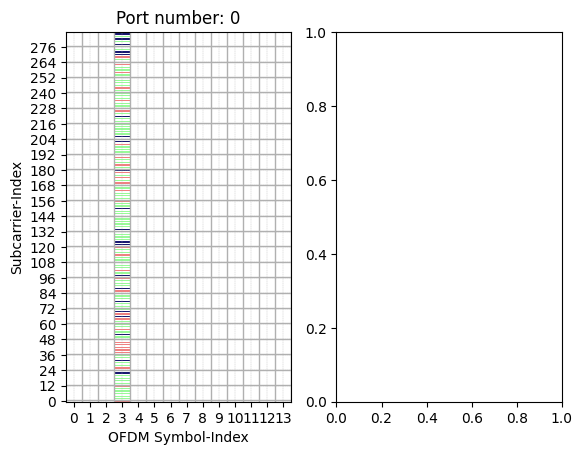

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='OFDM Symbol-Index', ylabel='Subcarrier-Index'>)

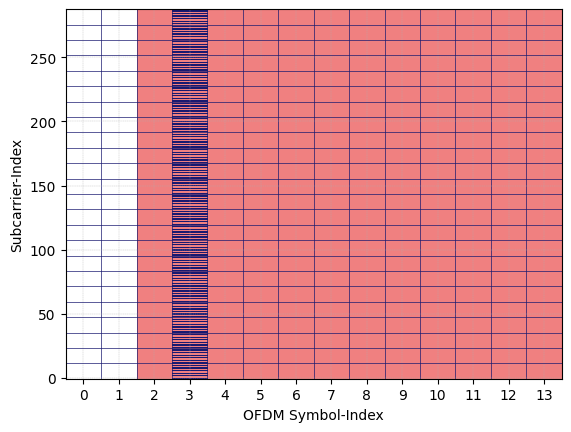

In [6]:

pdschUpperPhy = PDSCHUpperPhy(symbolsPerSlot = numSymbols, numRB = numRB, mcsIndex = mcsIndex, 
                              numlayers = numlayers, scalingField = scalingField, 
                              additionalOverhead = additionalOverhead, dmrsREs = dmrsREs, 
                              numTBs=numTBs, pdschTable = mcsTable, verbose = False)

codeword      = pdschUpperPhy(tblock = [None, None], rvid = [0, 0], enableLBRM = [False, False], 
                              numBatch = numBatches, numBSs = numBSs)

rnti          = np.random.randint(65536, size=numBSs*numBatches)
nID           = np.random.randint(1024,  size=numBSs*numBatches)
bits2         = codeword[1] if numTBs == 2 else None

pdschLowerPhyChain = PDSCHLowerPhy(pdschMappingType, configurationType, dmrsTypeAPosition, 
                                   maxLength, dmrsAdditionalPosition, l0, ld, l1)
resourceGrid  = pdschLowerPhyChain(codeword[0], numRB, rank, slotNumber, scramblingID, 
                                        nSCID, rnti, nID, modOrder, startSymbol, bits2 = bits2)

## Load the resource Grid into the transmision Grid
txGrid        = np.zeros(resourceGrid.shape[0:-1]+(Nfft,), dtype= np.complex64)
bwpOffset     = np.random.randint(Nfft-numRB*12)
txGrid[...,bwpOffset:bwpOffset+numRB*12] = resourceGrid

fig, ax       = pdschLowerPhyChain.displayDMRSGrid()
pdschLowerPhyChain.displayResourceGrid()

In [7]:
xBeam      = txGrid[...,np.newaxis]

print("************ Beamforming Parameters *************")
print()
print("     Channel Shape: "+str(Hf.shape))
print("Beamformed Grid sh: "+str(xBeam.shape))
print()
print("********************************************")

************ Beamforming Parameters *************

     Channel Shape: (1, 14, 1, 1, 1024, 1, 1)
Beamformed Grid sh: (100, 1, 1, 14, 1024, 1)

********************************************


## Pass through the Wireless Channel

In [8]:
# Channel Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots), numBSs, numUEs, numSamples/numFFTpoints, numRxAntennas, numTxAntennas
# Tx-Grid Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots), numBSs,         numSamples/numFFTpoints,                numTxAntennas
# Rx-Grid Dimensions: numBatches, numFrequencies, numSymbols(numSnapshots),   --    numUEs, numSamples/numFFTpoints, numRxAntennas

ptc = ApplyChannel(isFrequencyDomain = True, enableInterTxInterference = True, memoryConsumptionLevel = 0)
y   = ptc(Hf[np.newaxis].transpose(4,0,1,2,3,5,6,7), xBeam.transpose(0,1,3,2,4,5))

print("************ Channel Parameters *************")
print()
print("      Channel Shape: "+str(Hf.shape))
print("Received Grid shape: "+str(y.shape))
print(" Beamformed Grid sh: "+str(xBeam.shape))
print()
print("********************************************")

************ Channel Parameters *************

      Channel Shape: (1, 14, 1, 1, 1024, 1, 1)
Received Grid shape: (100, 1, 14, 1, 1024, 1)
 Beamformed Grid sh: (100, 1, 1, 14, 1024, 1)

********************************************


## Recevier Side Processing

In [9]:
numPoints  = 10
SNRdB      = np.linspace(-12, -4, numPoints, endpoint=True)
SNR        = 10**(SNRdB/10)

codedBER   = np.zeros(numPoints)
uncodedBER = np.zeros(numPoints)
bler       = np.zeros(numPoints)
throughput = np.zeros(numPoints)

for i in range(numPoints):
    print("********************************************************")
    print("Simulation: ["+str(i)+"] for      SNRdB = "+str(SNRdB[i]))
    
    ## Add noise to the received grid
    yGrid = AddNoise(False)(y, 1/SNR[i], 0)

    ## Extracting the Received Grid
    rxGrid = yGrid[:,0].transpose(0,2,4,1,3)[...,bwpOffset:bwpOffset+12*numRB]

    ## Receiver: Lower Physical layer
    channelEstimator = ChannelEstimationAndEqualizationPDSCH(slotNumber, scramblingID, nSCID, rnti, nID, pdschMappingType, configurationType, dmrsTypeAPosition,
                                                  maxLength, dmrsAdditionalPosition, l0, ld, l1, startSymbol, numTargetBits, modOrder, isUEmobile=False)

    symbolEstimates  = channelEstimator(rxGrid[:,0], interpolatorTypeFrequency = "linear") ## Equalized symbols. | Interpolator can be: "NN", "Linear", "Cubic"

    ## Receiver: Lower Physical layer

   # Symbol demapping
    lmObject = LayerDemapper(numTBs, rank)

    if(numTBs == 1):
        # Symbol demapping 1st TB
        # Shape of x must be numBatches x numUEs x numLayers x numBits
        rcodeword1 = lmObject(symbolEstimates.astype(np.complex64))

    else:
        # Symbol demapping 2nd TB
        rcodeword1, rcodeword2 = lmObject(symbolEstimates.astype(np.complex64))

    ##  ------------------ Symbol Demapping ------------------
    # The mapper maps blocks of information bits to constellation symbols
    demapper = Demapper("app", "qam", modOrder, hard_out = False)
    bits_1e  = demapper([rcodeword1, np.float32(1/SNR[i])])

    # Descrambling the pdsch payload bits
    deScrObject1      = DeScrambler("PDSCH", rnti, 0, nID)
    decscrambledBits1 = deScrObject1(bits_1e)
    decscrambledBits1 = np.where(decscrambledBits1>20, 20,   decscrambledBits1)
    decscrambledBits1 = np.where(decscrambledBits1<-20, -20, decscrambledBits1)


    if(numTBs == 2):
        bits_2e = demapper([rcodeword2, np.float32(1/SNR[i])])

        # Descrambling the pdsch payload bits
        deScrObject2      = DeScrambler("PDSCH", rnti, 1, nID)
        decscrambledBits2 = deScrObject2(bits_2e)
        decscrambledBits2 = np.where(decscrambledBits2>20, 20,   decscrambledBits2)
        decscrambledBits2 = np.where(decscrambledBits2<-20, -20, decscrambledBits2)


    if(numTBs == 1):
        uncodedBits    = [np.zeros(decscrambledBits1.shape)]
        uncodedBits[0][decscrambledBits1 > 0] = 1
        decscrambledOut = (decscrambledBits1,)

    else:
        uncodedBits = [np.zeros(decscrambledBits1.shape), np.zeros(decscrambledBits2.shape)]
        uncodedBits[0][decscrambledBits1 > 0] = 1
        uncodedBits[1][decscrambledBits2 > 0] = 1

        decscrambledOut = (decscrambledBits1, decscrambledBits2)

    ## Receiver: Upper Physical layer
    pdschUpPhyDec = PDSCHDecoderUpperPhy(numTBs = numTBs, mcsIndex = mcsIndex, symbolsPerSlot= numSymbols,
                                         numRB  = numRB, numLayers = numlayers, scalingField = scalingField,
                                         additionalOverhead = additionalOverhead, dmrsREs = dmrsREs,
                                         enableLBRM = [False, False], pdschTable = mcsTable, rvid = [0, 0], verbose=False)

    if numTBs == 2:
        bits = pdschUpPhyDec(decscrambledOut)
    else:
        bits = pdschUpPhyDec(decscrambledOut)


    if numTBs == 1:
        ## KPI computation
        codedBER[i]   = np.mean(np.abs(bits-pdschUpperPhy.tblock1[:,0]))
        uncodedBER[i] = np.mean(np.abs(uncodedBits[0] - codeword[0][:,0]))
        bler[i]       = 1-np.mean(pdschUpPhyDec.crcCheckforCBs)
        throughput[i] = (1-bler[i])*tbLen1*2000

    else:
        ## KPI computation
        codedBER[i]   = np.mean(np.abs(np.concatenate([bits[0], bits[1]], axis=-1) - np.concatenate([pdschUpperPhy.tblock1[:,0], pdschUpperPhy.tblock2[:,0]], axis=-1)))
        uncodedBER[i] = np.mean(np.abs(np.concatenate([uncodedBits[0], uncodedBits[1]], axis=-1) - np.concatenate([codeword[0][:,0], codeword[1][:,0]], axis=-1)))
        bler[i]       = 1-np.mean(pdschUpPhyDec.crcCheckforCBs)
        throughput[i] = ((1-bler[i])*tbLen1*2000) + ((1-bler[i])*tbLen2*2000)


    print("Simulation: "+str([i])+" for       BLER = "+str(bler[i]))
    print("Simulation: "+str([i])+" for Throughput = "+str(throughput[i]))

    print("********************************************************")
    print()

********************************************************
Simulation: [0] for      SNRdB = -12.0
Simulation: [0] for       BLER = 0.95
Simulation: [0] for Throughput = 167200.00000000015
********************************************************

********************************************************
Simulation: [1] for      SNRdB = -11.11111111111111
Simulation: [1] for       BLER = 0.83
Simulation: [1] for Throughput = 568480.0000000001
********************************************************

********************************************************
Simulation: [2] for      SNRdB = -10.222222222222221
Simulation: [2] for       BLER = 0.53
Simulation: [2] for Throughput = 1571679.9999999998
********************************************************

********************************************************
Simulation: [3] for      SNRdB = -9.333333333333334
Simulation: [3] for       BLER = 0.10999999999999999
Simulation: [3] for Throughput = 2976160.0
*************************************

## Simulation Results: Reliability

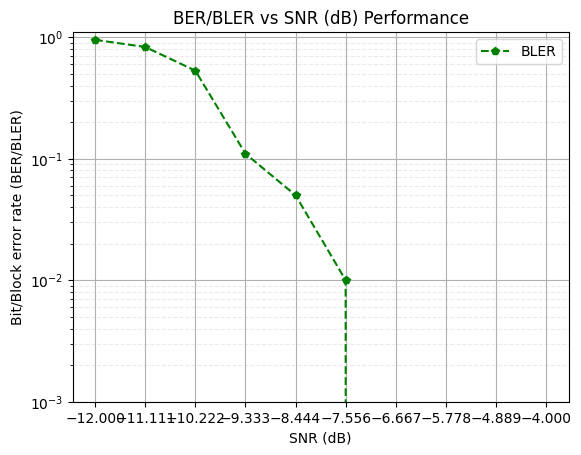

In [10]:
fig, ax = plt.subplots()

# ax.semilogy(SNRdB, uncodedBER, "-b", marker = "o", label="uncodedBER")
# ax.semilogy(SNRdB, codedBER,   ":r", marker = "s", label="codedBER")
ax.semilogy(SNRdB, bler,      "--g", marker = "p", label="BLER")
ax.legend(loc="best")

ax.set_xticks(SNRdB)
ytck = (0.1**(np.arange(1, 8))).repeat(9)*np.tile(np.arange(10, 1,-1), [7])
ytck = np.concatenate([[1],ytck])
ax.set_yticks(ytck, minor=True)
ax.set_yticks(0.1**(np.arange(0, 7)), minor=False)
ax.set_ylim([0.001,1.1])

ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlabel("SNR (dB)")
ax.set_ylabel("Bit/Block error rate (BER/BLER)")
ax.set_title("BER/BLER vs SNR (dB) Performance")

plt.show()

fig.savefig("PDSCH_BLER_LLS-NTN.png", format = "png", transparent = True)
fig.savefig("PDSCH_BLER_LLS-NTN.svg", format = "svg", transparent = True)


## Simulation Results: Throughput

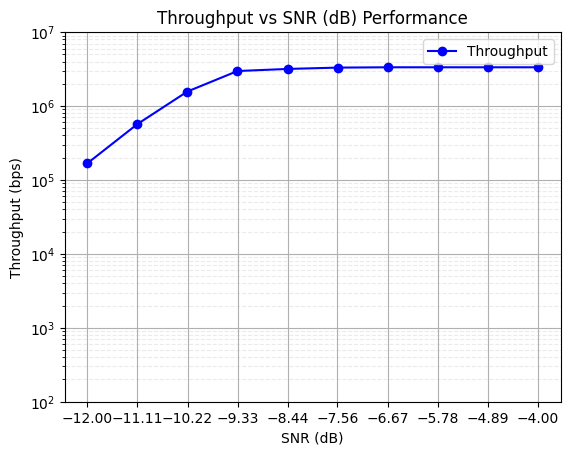

In [11]:
fig, ax = plt.subplots()

ax.semilogy(SNRdB, throughput, "-b", marker = "o", label="Throughput")
ax.legend(loc="best")

ax.set_xticks(np.round(SNRdB, 2), minor=False)
ytck = 10**(np.arange(2, 9)).repeat(9)*np.tile(np.arange(1, 10), [7])
ax.set_yticks(ytck, minor=True)
ax.set_yticks(10**(np.arange(2, 8)), minor=False)
ax.set_ylim([10**2, 10**7])
ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlabel("SNR (dB)")
ax.set_ylabel("Throughput (bps)")
ax.set_title("Throughput vs SNR (dB) Performance")

plt.show()

fig.savefig("PDSCH_Throughput_LLS-NTN.png", format = "png", transparent = True)
fig.savefig("PDSCH_Throughput_LLS-NTN.svg", format = "svg", transparent = True)


## Simulation Results: Reliability (Averaged over 32000 batches)

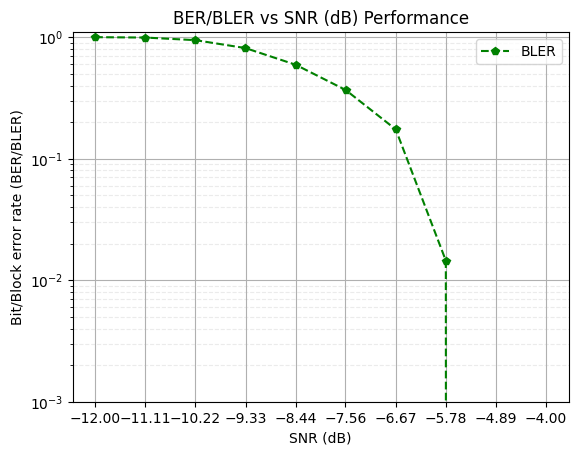

In [12]:
mcsIndex = 3
rank     = 1
filename = "Databases/PDSCH-mcsIndex"+str(mcsIndex)+"-rank"+str(rank)+"-dB.npz"
dB       = np.load(filename)

SNRdB2      = dB["SNRdB"]
codedBER2   = dB["codedBER"]
uncodedBER2 = dB["uncodedBER"]
bler2       = dB["bler"]
throughput2 = dB["throughput"]

fig, ax = plt.subplots()

# ax.semilogy(SNRdB, uncodedBER, "-b", marker = "o", label="uncodedBER")
# ax.semilogy(SNRdB, codedBER,   ":r", marker = "s", label="codedBER")
ax.semilogy(SNRdB2, bler2,      "--g", marker = "p", label="BLER")
ax.legend(loc="best")

ax.set_xticks(np.round(SNRdB2, 2))
ytck = (0.1**(np.arange(1, 8))).repeat(9)*np.tile(np.arange(10, 1,-1), [7])
ytck = np.concatenate([[1],ytck])
ax.set_yticks(ytck, minor=True)
ax.set_yticks(0.1**(np.arange(0, 7)), minor=False)
ax.set_ylim([0.001,1.1])

ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlabel("SNR (dB)")
ax.set_ylabel("Bit/Block error rate (BER/BLER)")
ax.set_title("BER/BLER vs SNR (dB) Performance")

plt.show()

fig.savefig("PDSCH_BLER_LLS-NTN.png", format = "png", transparent = True)
fig.savefig("PDSCH_BLER_LLS-NTN.svg", format = "svg", transparent = True)


## Simulation Results: Throughput (Averaged over 32000 batches)

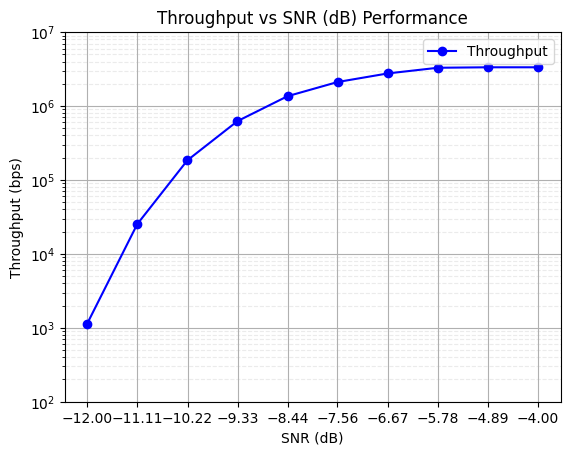

In [13]:
fig, ax = plt.subplots()

ax.semilogy(SNRdB2, throughput2, "-b", marker = "o", label="Throughput")
ax.legend(loc="best")

ax.set_xticks(np.round(SNRdB2, 2), minor=False)
ytck = 10**(np.arange(2, 9)).repeat(9)*np.tile(np.arange(1, 10), [7])
ax.set_yticks(ytck, minor=True)
ax.set_yticks(10**(np.arange(2, 8)), minor=False)
ax.set_ylim([10**2, 10**7])
ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)

ax.set_xlabel("SNR (dB)")
ax.set_ylabel("Throughput (bps)")
ax.set_title("Throughput vs SNR (dB) Performance")

plt.show()

fig.savefig("PDSCH_Throughput_LLS-NTN.png", format = "png", transparent = True)
fig.savefig("PDSCH_Throughput_LLS-NTN.svg", format = "svg", transparent = True)
